# this notebook groups together the relevance maps based on hypothesis-driven clusters of behaviors

Written by Angela Tam & CBIG under MIT license: https://github.com/ThomasYeoLab/CBIG/blob/master/LICENSE.md

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import stats
import scipy.cluster.hierarchy as sch
import os

In [2]:
# set random seed
np.random.seed(seed=1)

In [3]:
# function to plot correlation matrix
# size is a tuple e.g.(10,8)
def plot_raw_matrix(array, list_var, c_dict, size, path_out=None, fname=None):
    df = pd.DataFrame(data=array, columns=list_var)
    df_corr = df[list_var].corr()
    plt.figure(figsize=size)
    g = sns.heatmap(df_corr, vmin=-0.8, vmax=0.8, cmap="BrBG",
               xticklabels=df_corr.columns,
               yticklabels=df_corr.columns)
    for tick_label in g.get_yticklabels():
        tick_text = tick_label.get_text()
        tick_label.set_color(c_dict[tick_text])
    for tick_label in g.get_xticklabels():
        tick_text = tick_label.get_text()
        tick_label.set_color(c_dict[tick_text])
    if isinstance(path_out, str):
        plt.savefig(path_out + '/sim_matrix_' + fname + '.pdf')

In [4]:
# function to reorder a matrix
def rearrange_matrix_sig(array, idx):
    nn = 0
    new_mat = np.zeros((array.shape[0], len(idx)))
    for i in idx:
        new_mat[:,nn] = array[:,i]
        nn += 1
    return new_mat

### SET OUTPUT DIRECTORY

In [5]:
# set output directory, default is None - no output will be saved unless changed
path_out = None

### set up variables

In [6]:
# input directory
in_dir = os.getenv('CBIG_CODE_DIR') + '/stable_projects/predict_phenotypes/ChenTam2021_TRBPC/figure_utilities/input'

In [7]:
# replication directory
rep_dir = os.getenv('CBIG_REPDATA_DIR') + '/stable_projects/predict_phenotypes/ChenTam2021_TRBPC/figures'

In [8]:
# get a list of all predicted variables/outcomes
list_var = []
with open(in_dir + '/variables_to_predict.txt') as file:
    for line in file:
        line = line.strip()
        list_var.append(line)

In [9]:
# list of behaviors that were significantly predicted
list_sig_r = ['vocabulary','working memory','reading',
              'crystallized cognition','attention','overall cognition',
              'executive function','fluid cognition','processing speed',
              'episodic memory','short delay recall','long delay recall',
              'fluid intelligence','visuospatial accuracy','visuospatial efficiency',
              'visuospatial reaction time','lack of planning','sensation seeking',
              'lack perseverance','negative urgency','positive urgency',
              'behavioral inhibition','fun seeking','reward responsiveness',
              'drive','total psychosis symptoms','psychosis severity',
              'somatic complaints','thought problems','attention problems',
              'anxious depressed','social problems']

In [10]:
# get indices from original list (list_var) that match the list_sig_r
idx_sig = [list_var.index(i) for i in list_sig_r]

In [11]:
# dictionary for colours of different behavioural scales
c_dict = {'vocabulary':'red',
          'attention':'red',
          'working memory':'red',
          'executive function':'red',
          'processing speed':'red',
          'episodic memory':'red',
          'reading':'red',
          'fluid cognition':'red',
          'crystallized cognition':'red',
          'overall cognition':'red',
          'short delay recall':'firebrick',
          'long delay recall':'firebrick',
          'fluid intelligence':'orangered',
          'visuospatial accuracy':'lightcoral',
          'visuospatial reaction time':'lightcoral',
          'visuospatial efficiency':'lightcoral',
          'anxious depressed':'blue',
          'somatic complaints':'blue',
          'social problems':'blue',
          'thought problems':'blue',
          'attention problems':'blue',
          'total psychosis symptoms':'cornflowerblue',
          'psychosis severity':'cornflowerblue',
          'negative urgency':'black',
          'lack of planning':'black',
          'sensation seeking':'black',
          'positive urgency':'black',
          'lack perseverance':'black',
          'behavioral inhibition':'dimgrey',
          'reward responsiveness':'dimgrey',
          'drive':'dimgrey',
          'fun seeking':'dimgrey'}

## cluster when all the fmri conditions are stacked together

In [12]:
# load the data
mat_stack = sio.loadmat(rep_dir + '/stacked_relevance_vectors.mat')

In [13]:
mat_stack['stack'].shape

(350284, 36)

In [14]:
# take only the significant scores and rearrange
stacked_mat = rearrange_matrix_sig(mat_stack['stack'], idx_sig)

In [15]:
stacked_mat.shape

(350284, 32)

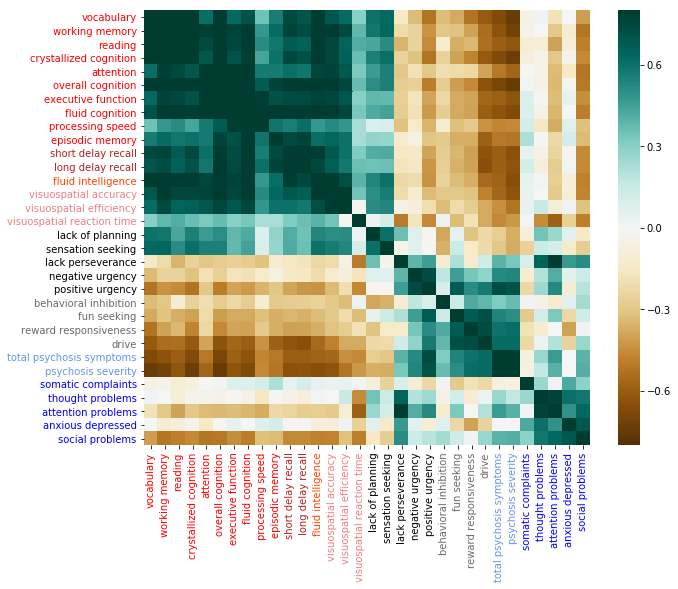

In [16]:
plot_raw_matrix(stacked_mat, list_sig_r, c_dict, (10,8), path_out, 'hypothesis_stacked')

### correlations between behavioral categories

In [17]:
df = pd.DataFrame(data=stacked_mat, columns=list_sig_r)
df_corr = df[list_sig_r].corr()

In [18]:
# cognition & cognition (lower triangle, no diagonal)
cog_tril = np.tril(df_corr.loc['vocabulary':'visuospatial reaction time',
                               'vocabulary':'visuospatial reaction time'].values,-1)
cog_tril[np.nonzero(cog_tril)].mean()

0.6814086876939953

In [19]:
# cognition & personality block
df_corr.loc['vocabulary':'visuospatial reaction time','lack of planning':'drive'].values.mean()

-0.15878400275677965

In [20]:
# cognition & mental health block
df_corr.loc['vocabulary':'visuospatial reaction time',
            'total psychosis symptoms':'social problems'].values.mean()

-0.2851623236458244

In [21]:
# personality & personality (lower triangle, no diagonal)
pers_tril = np.tril(df_corr.loc['lack of planning':'drive',
                               'lack of planning':'drive'].values,-1)
pers_tril[np.nonzero(pers_tril)].mean()

0.2088959137125926

In [22]:
# personality & mental health block
df_corr.loc['lack of planning':'drive','total psychosis symptoms':'social problems'].values.mean()

0.15303273869929296

In [23]:
# mental health & mental health (lower triangle, no diagonal)
mh_tril = np.tril(df_corr.loc['total psychosis symptoms':'social problems',
                              'total psychosis symptoms':'social problems'].values,-1)
mh_tril[np.nonzero(mh_tril)].mean()

0.36852976160756407

## giant matrix of all behavioural maps across all conditions 

In [24]:
# load data
mat_fc = sio.loadmat(rep_dir + '/relevance_vectors.mat')

In [25]:
# grab only signficant scores from each condition 
rs_mat = rearrange_matrix_sig(mat_fc['struct_fc_vec']['rs'][0][0], idx_sig)
mid_mat = rearrange_matrix_sig(mat_fc['struct_fc_vec']['mid'][0][0], idx_sig)
nback_mat = rearrange_matrix_sig(mat_fc['struct_fc_vec']['nback'][0][0], idx_sig)
sst_mat = rearrange_matrix_sig(mat_fc['struct_fc_vec']['sst'][0][0], idx_sig)

#### new matrix with all scores together in new order (cognition together, personality together, mental health together)

In [26]:
concat_mat_clus = np.zeros((87571, 128))

In [27]:
nn = 0
for bb in range(rs_mat.shape[1]): # for each sig. behavior
    concat_mat_clus[:,nn] = rs_mat[:,bb] # put in rs
    nn += 1
    concat_mat_clus[:,nn] = mid_mat[:,bb] # put in mid
    nn += 1
    concat_mat_clus[:,nn] = sst_mat[:,bb] # put in sst
    nn += 1
    concat_mat_clus[:,nn] = nback_mat[:,bb] # put in nback
    nn += 1

#### set up dictionary for colouring labels

In [28]:
list_fmri = ['REST ', 'MID ', 'SST ', 'NBACK ']
list_sig_r_fmri_clus = []
for behav in list_sig_r:
    for fmri in list_fmri:
        tmp = fmri + behav
        list_sig_r_fmri_clus.append(tmp)

In [29]:
colours = ['red', #'vocabulary'
          'red', #'working memory'
          'red', #'reading'
          'red', #'crystallized cognition'
          'red', #'attention'
          'red', #'overall cognition'
          'red', #'executive function'
          'red', #'fluid cognition'
          'red', #'processing speed'
          'red', #'episodic memory'
          'firebrick', #'short delay recall'
          'firebrick', #'long delay recall'
          'orangered', #'fluid intelligence'
          'lightcoral', #'visuospatial accuracy'
          'lightcoral', #'visuospatial efficiency'
          'lightcoral', #'visuospatial reaction time'
          'black', #'lack of planning'
          'black', #'sensation seeking'
          'black', #'lack perseverance'
          'black', #'negative urgency'
          'black', #'positive urgency'
          'dimgrey', #'behavioral inhibition'
          'dimgrey', #'fun seeking'
          'dimgrey', #'reward responsiveness'
          'dimgrey', #'drive'
          'cornflowerblue', #'total psychosis symptoms'
          'cornflowerblue', #'psychosis severity'
          'blue', #'somatic complaints'
          'blue', #'thought problems'
          'blue', #'attention problems'
          'blue', #'anxious depressed'
          'blue'] #'social problems'

In [30]:
colours_fmri = []
for cc in colours:
    colours_fmri.append(cc)
    colours_fmri.append(cc)
    colours_fmri.append(cc)
    colours_fmri.append(cc)

In [31]:
fmri_c_dict_clus = dict(zip(list_sig_r_fmri_clus, colours_fmri))

#### plot

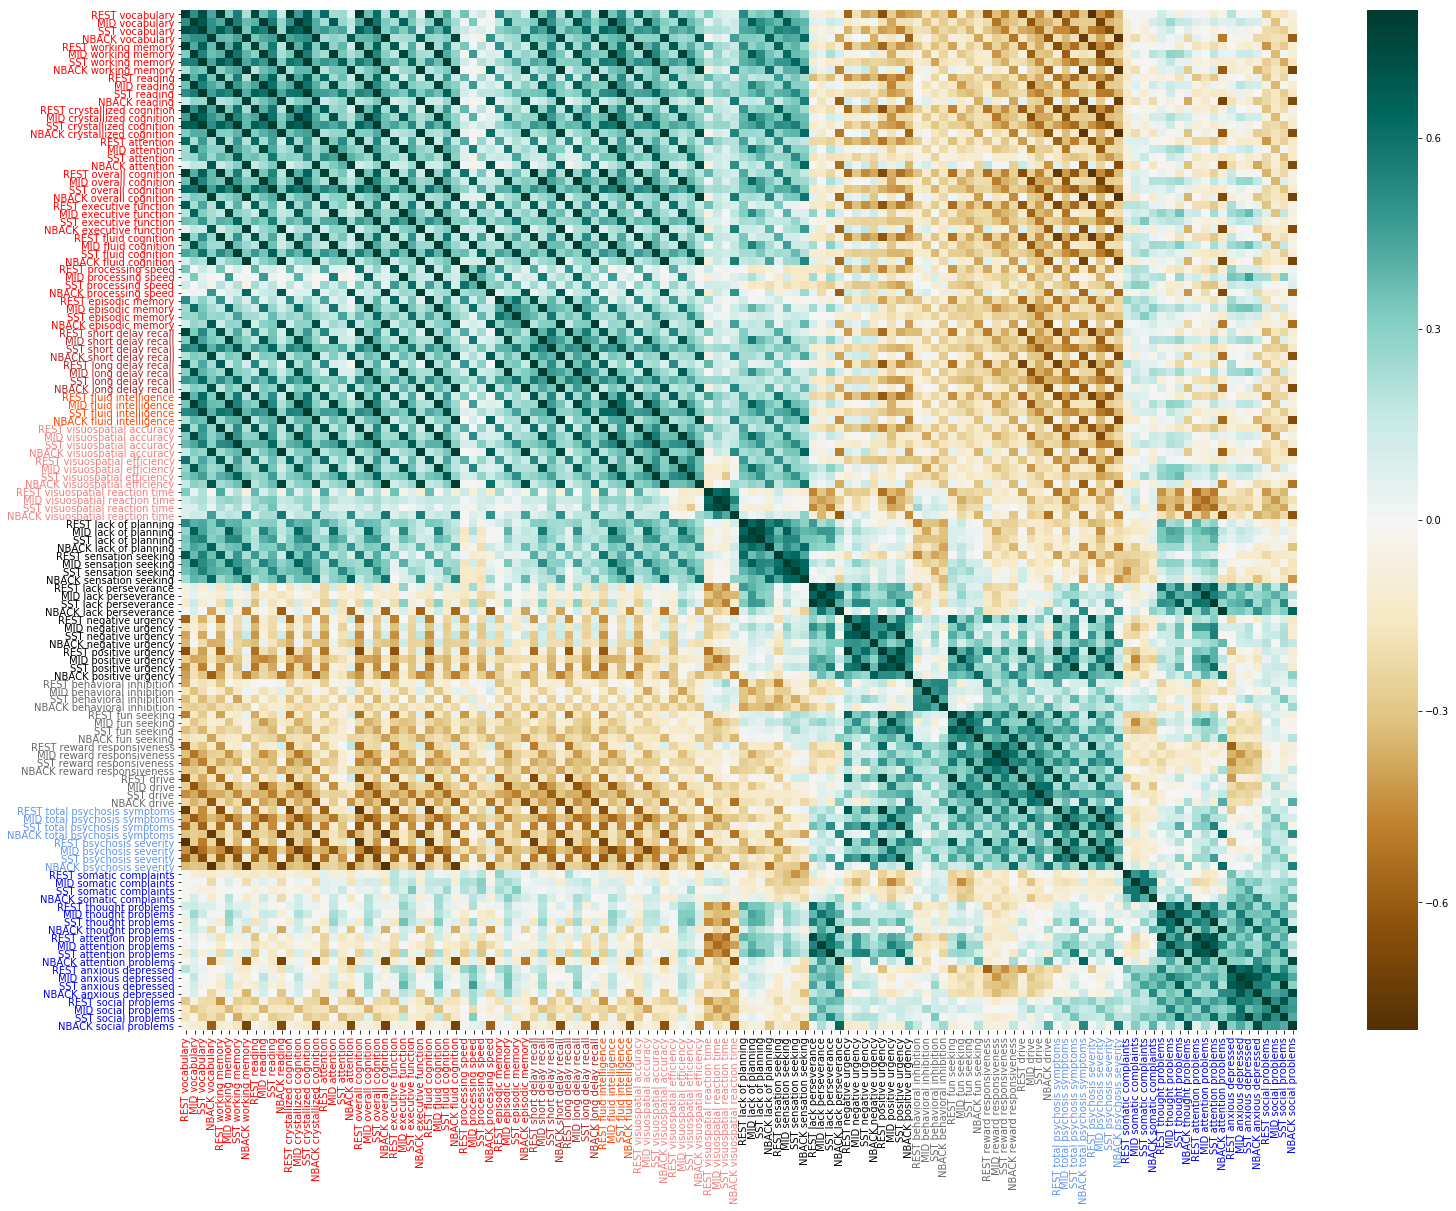

In [32]:
plt.rcParams.update({'font.size': 10})
plot_raw_matrix(concat_mat_clus, list_sig_r_fmri_clus, fmri_c_dict_clus, (25,18.75), path_out, 'hypothesis_ind')